In [1]:
import numpy as np
from datetime import datetime, timedelta
import pylab
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import math
import pandas.tseries.offsets as ofs
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa import stattools

import warnings as w
from IPython.display import Image

from utils import qualityMACAPE, qualityRMSE, InitExponentialSmoothing, AdaptiveExponentialSmoothing

%matplotlib inline

In [2]:
import scipy.linalg as sc

<h1 align="center"> Practice: realize compositions</h1>
# Adaptive selection
** Question:**
* What is adaptive selection?
* Which external parameters does it have?
* Describe case when adaptive selection works bad.

In [3]:
def adaptive_selection(x, h, params):
    '''
    Parameters
    x <array> - time series
    h <integer scalar> - forecasting delay
    params <dict> - dictionary with 
        gamma <scalar in [0,1]> - smoothing parameter of error
        eps <scalar> - bound for best indistinctive models
        base_algs - array of <dict> with params
            base_alg <string> - name of base algorithm
            BaseAlfParams <dict> dictionary of base algorithm's params
    '''
    T = len(x)
    FORECAST = [np.nan] * (T + h)
    
    # base algs Forecasts
    base_algs = params['base_alg_params']
    N = len(base_algs)
    
    FORECAST_BA = np.empty( (N, T + h) )
    FORECAST_BA[:] = np.nan
    
    #     forecast TS by each base algs
    for n in range(N):
        FORECAST_BA[n] = eval(base_algs[n]['base_alg']+"(x,h,"+"base_algs["+str(n)+"]['base_algs_params'])")
        
    # internal params of composition
    gamma = params['gamma']
    eps = params['eps']
    
    if gamma > 1:
        w.warn('Gamma can not be more than 1')
        #alpha = 1
        return FORECAST
    if gamma < 0:
        w.warn('Gamma can not be less than 0')
        #alpha = 0
        return FORECAST
    
    e1 = np.zeros(N)  # initialization of errors of base algorithms 
    j_best = 0

    y = 1.5
    for t in range(0, T):
        if not np.isnan(x[t]) and not (np.isnan(FORECAST_BA.T[t])).any():
            e1 = gamma * np.abs(x[t] - FORECAST_BA.T[t]) + (1 - gamma) * e1
            # select best algorithm at the moment t
            j_best = np.argmin(e1)
            # select best indistinctive
            idx_bestinsdistinctive = e1 <= (e1[j_best] + eps)
            bestinsdistinctive = FORECAST_BA[:, t][idx_bestinsdistinctive]
            if len(bestinsdistinctive):
                y = bestinsdistinctive.mean()
        FORECAST[t+h] = y
    return FORECAST

# Define base algorithms

In [4]:
base_algs = [{'base_alg':'InitExponentialSmoothing', 'base_algs_params':{'alpha':0.1, 'AdaptationPeriod':10}},
            {'base_alg':'AdaptiveExponentialSmoothing', 'base_algs_params':{'alpha':0.2,'gamma':0.01, 'AdaptationPeriod':10}}
#                  {'base_alg':'AdaptiveSimpleExponentialSmoothing', 'base_algs_params':{'alpha':0.1, 'gamma':0.01}},
#                 {'base_alg':'TheilWageSmoothing', 'base_algs_params':{'alpha':0.3, 'beta':0.9,'delta':0.9}}
]

In [5]:
for ba in range(len(base_algs)):
    print(base_algs[ba]['base_alg']+"(x,h,"+"base_algs["+str(ba)+"]['base_alg_params'])")

InitExponentialSmoothing(x,h,base_algs[0]['base_alg_params'])
AdaptiveExponentialSmoothing(x,h,base_algs[1]['base_alg_params'])


In [6]:
# Read datae (time series)
# ts = pd.read_csv('https://raw.githubusercontent.com/ml-mipt/ml-mipt-part2/master/2017/seminars/1_ts_esm/data/TimeSeries_Data10.csv', sep=',', decimal='.', parse_dates=True, dayfirst=True, index_col='Dates')
ts = pd.read_csv('./data/TimeSeries_Data10.csv', sep=',', decimal='.', parse_dates=True, dayfirst=True, index_col='Dates')
ts.index.names = ['Timestamp']
ts = ts.sort_index() # sort index

In [7]:
# Define forecast perameters
h = 1 # horizon forecast

# structure of forecasts
frc_ts = pd.DataFrame(index = ts.index.append(pd.date_range(ts.index[-1]+timedelta(1), ts.index[-1]+timedelta(h))), columns = ts.columns)
FRC_TS = dict()

In [8]:
# run (build forecast) simple exponential smoothing
for cntr in ts.columns:
    frc_ts[cntr] = AdaptiveExponentialSmoothing(ts[cntr],h, {'alpha':0.1,'gamma':0.01,  'AdaptationPeriod':10})

In [9]:
# run Adaptive Selection
gamma = 0.01
eps = 1.0
for cntr in ts.columns:
    frc_ts[cntr] = adaptive_selection(ts[cntr],h, {'gamma':gamma, 'eps': eps, 'base_alg_params':base_algs})
FRC_TS['AS gamma %.2f eps %.2f' % (gamma, eps)] = frc_ts

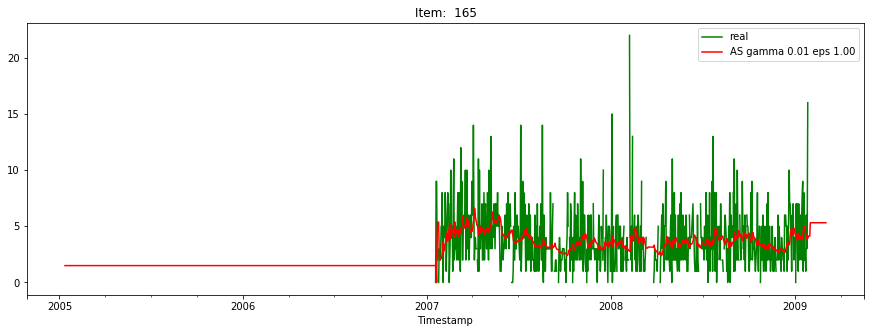

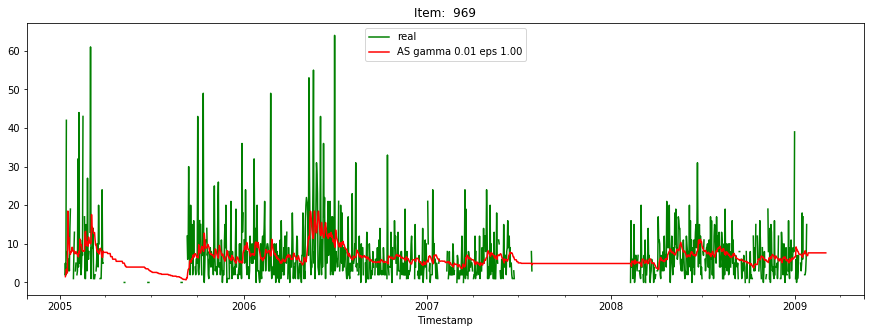

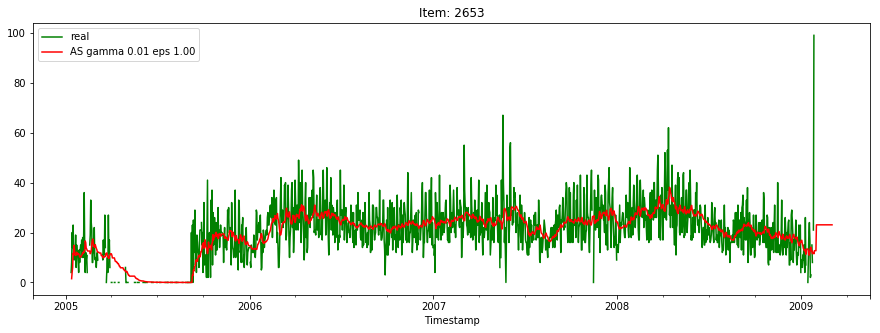

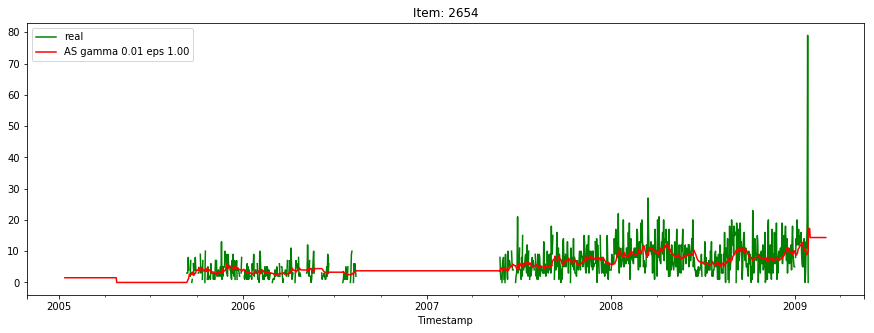

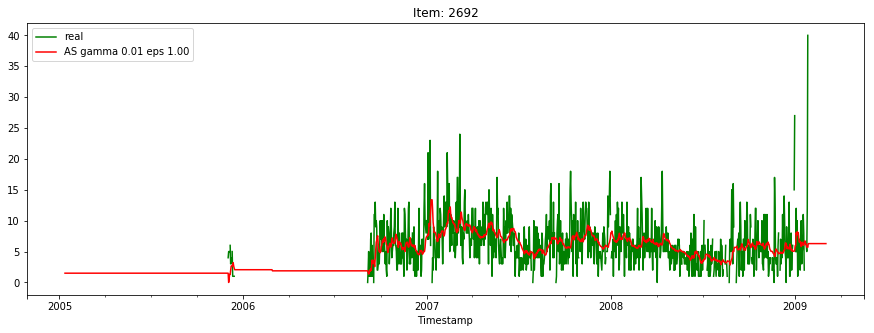

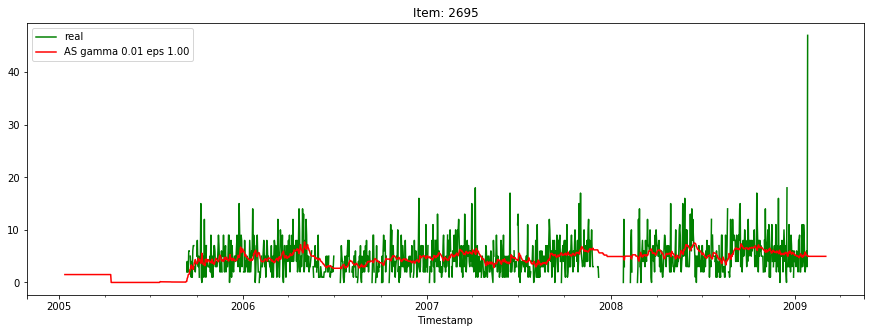

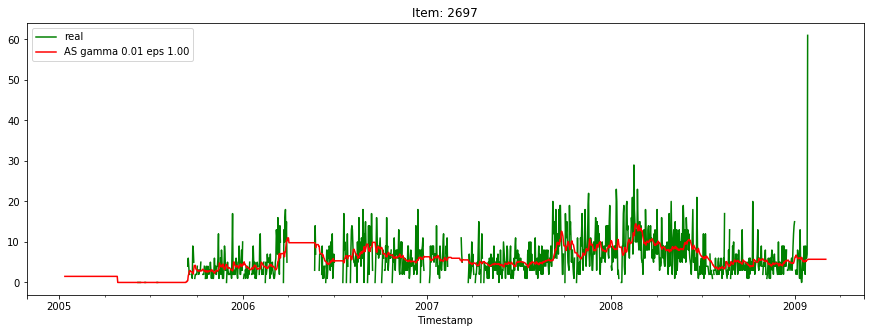

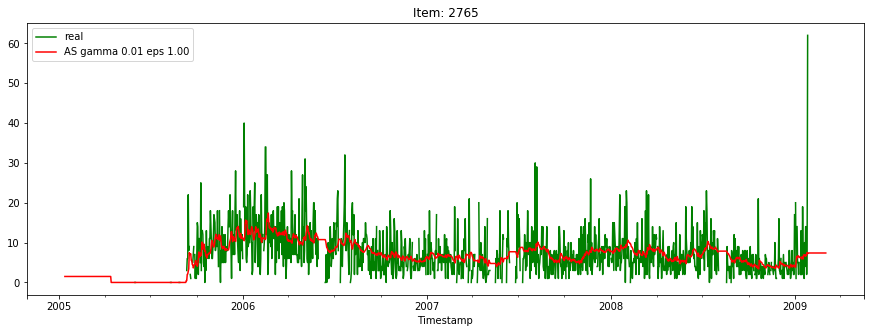

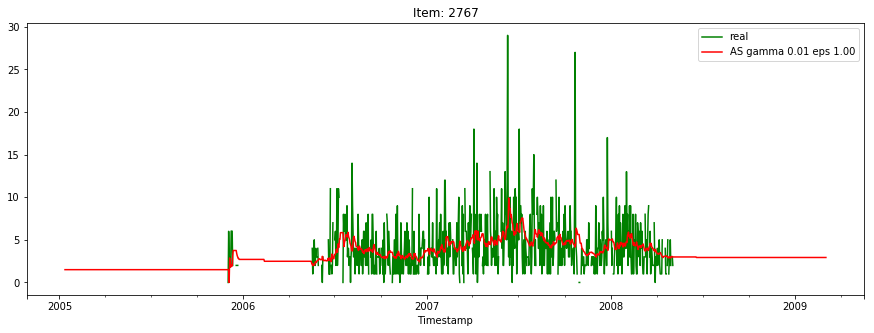

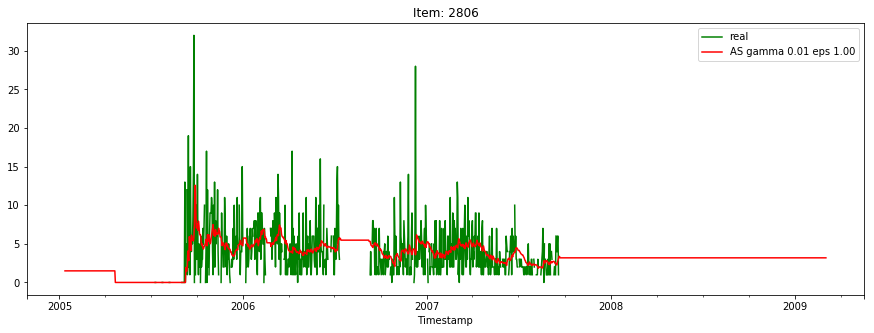

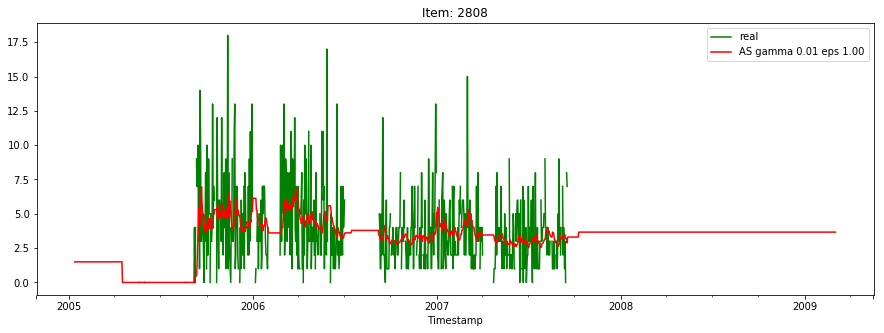

In [11]:
# draw forecast of Adaprive Selection
alg_name = 'AS gamma 0.01 eps 1.00'
for col in ts.columns:
    ts[col].plot(figsize=(15,5), color='green', label='real')
    forecast = FRC_TS[alg_name]
    forecast[col].plot(color='red', label=alg_name)
    plt.title(col)
    plt.legend()
    plt.show()

# Adaptive composition

In [12]:
def adaptive_composition(x, h, params):
    '''
    Parameters
    x <array> - time series
    h <integer scalar>- forecasting delay
    params <dict> - dictionary with 
        gamma <scalar in [0,1]> - smoothing parameter of error
        base_algs - array of <dict> with params
            base_alg <string> - name of base algorithm
            base_alg_params <dict> dictionary of base algorithm's params
    '''
    T = len(x)
    FORECAST = [np.nan] * (T + h)
    
    # base algs Forecasts     
    base_algs = params['base_alg_params']
    N = len(base_algs)
    
    FORECAST_BA = np.empty( (N, T + h) )
    FORECAST_BA[:] = np.nan
    
    #     forecast TS by each base algs
    #     be careful with eval() function    
    for n in range(N):
        FORECAST_BA[n] = eval(base_algs[n]['base_alg']+"(x,h,"+"base_algs["+str(n)+"]['base_algs_params'])")

    # internal params of composition
    gamma = params['gamma']
    
    if gamma>1:
        w.warn('Gamma can not be more than 1')
        #alpha = 1
        return FORECAST
    if gamma<0:
        w.warn('Gamma can not be less than 0')
        #alpha = 0
        return FORECAST
    
    e1 = np.ones(N)  # initialization of errors of base algorithms 
    weights = np.zeros(N)
    
    y = 1.5
    
    for t in range(0, T):
        if not math.isnan(x[t]):
            if t>= h:
                e1 = gamma*np.abs(x[t]-FORECAST_BA.transpose()[t])+(1-gamma)*e1
                # select best algorithm at the moment t
                if np.isnan(np.sum(e1)):
                    e1 = np.ones(N)
                e = np.power( np.array(e1), (-1) )
                weights = e / np.sum(e)
                
                # Calculate forecast of the composition
                y = FORECAST_BA.transpose()[t].dot(weights)
            
        FORECAST[t+h] = y
    return FORECAST

In [13]:
# run (build forecast) Adaptive Composition
gamma = 0.01

for cntr in ts.columns:
    frc_ts[cntr] = adaptive_composition(ts[cntr],h, {'gamma':gamma, 'base_alg_params':base_algs})
FRC_TS['AC gamma %.2f' % (gamma)] = frc_ts

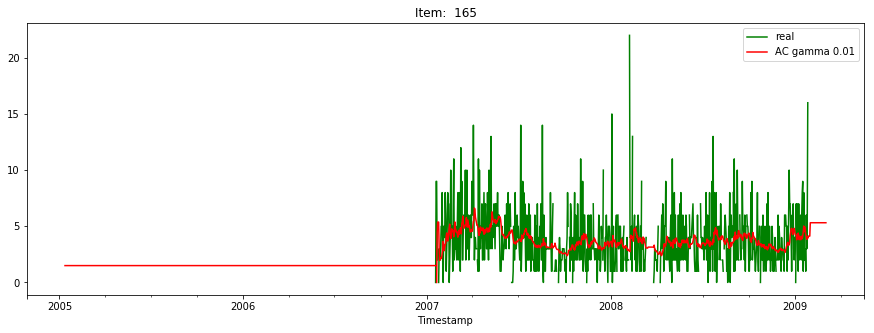

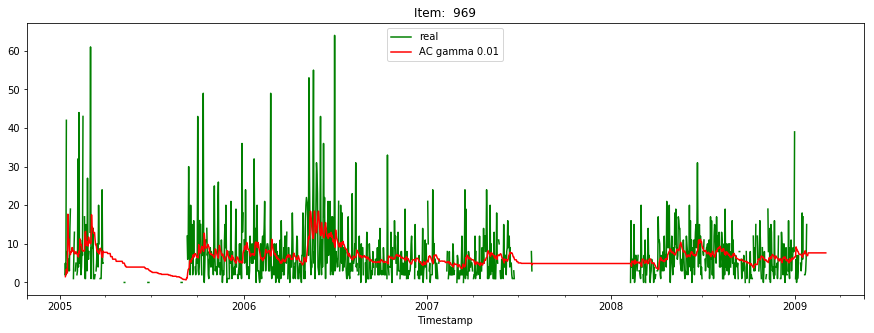

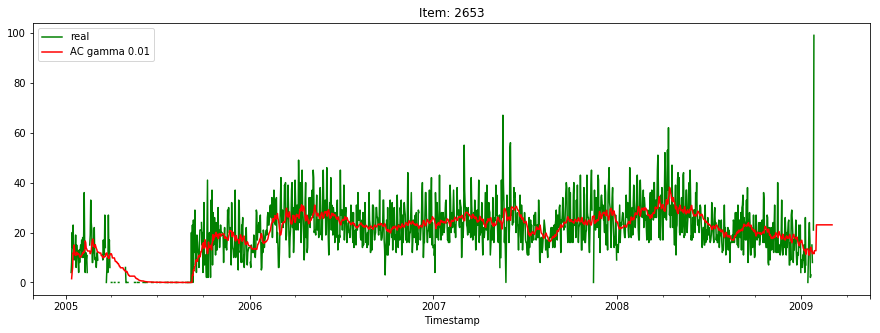

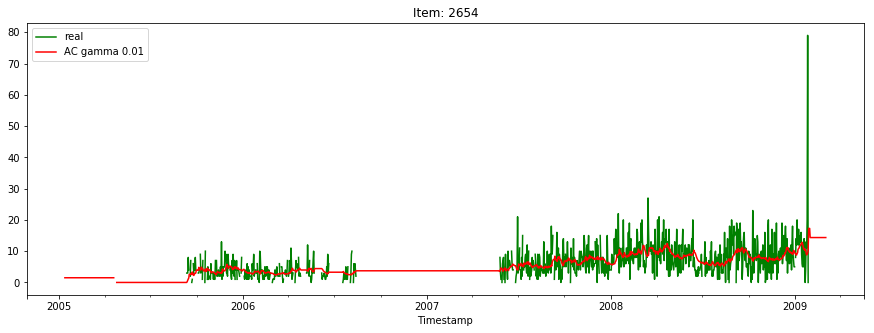

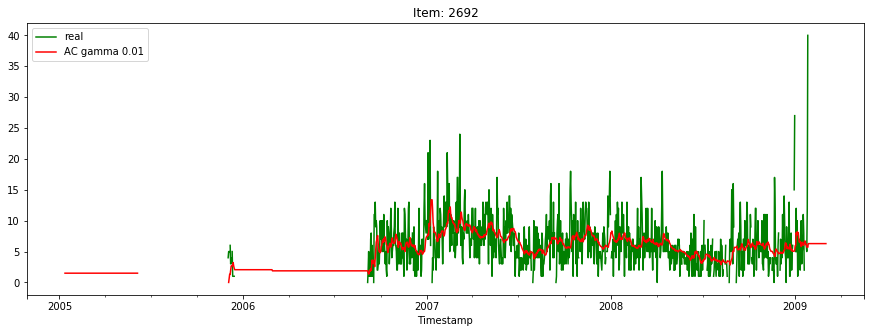

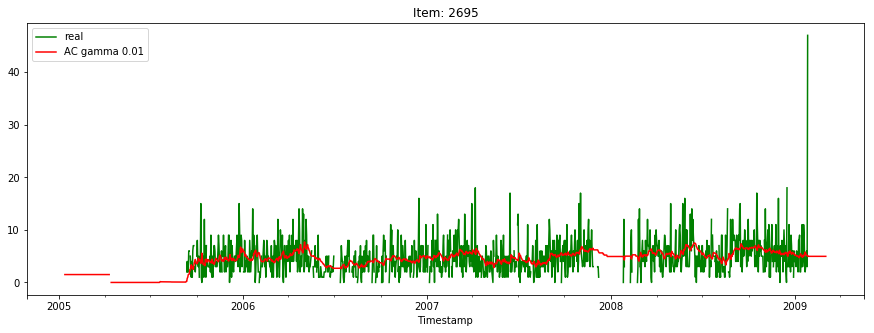

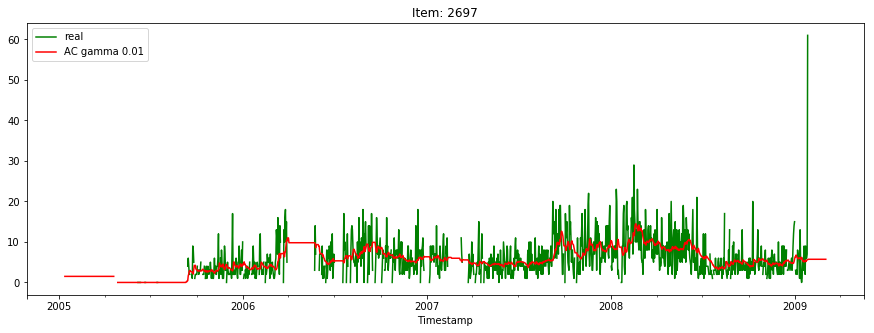

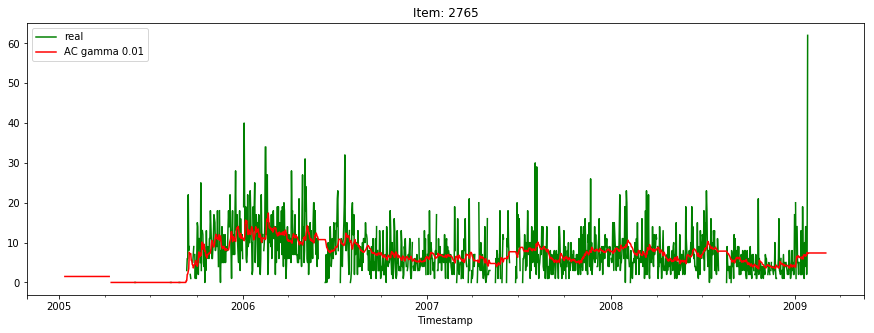

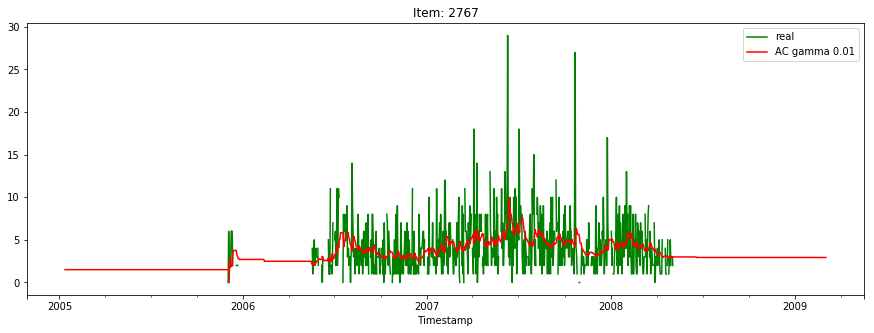

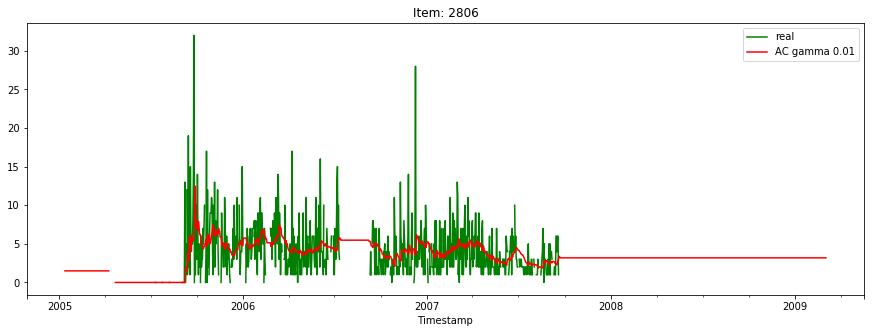

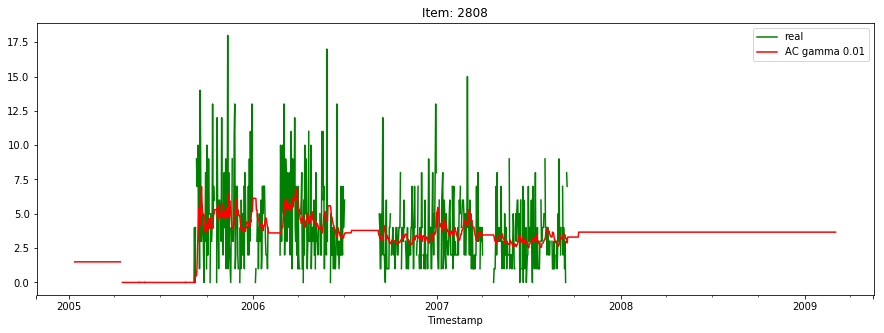

In [14]:
# draw forecast of Adaptive Composition
alg_name = 'AC gamma 0.01'
for col in ts.columns:
    ts[col].plot(figsize=(15,5), color='green', label='real')
    forecast = FRC_TS[alg_name]
    forecast[col].plot(color='red', label=alg_name)
    plt.title(col)
    plt.legend()
    plt.show()